In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
M, N = 90, 100
imageSize = (M, N)

### Functions: 

In [3]:
def calLoss(moving, reference):
    return np.sum((moving-reference)**2)

In [4]:
def getCoorMatrix(imageShape):
    yShape, xShape = imageSize
    coorMatrix = np.asarray(np.meshgrid(np.arange(xShape), np.arange(yShape)))
    coorMatrix = np.rollaxis(coorMatrix, 0, 3)
    return coorMatrix
    

In [76]:
def getFourCorners(transformMatrix):
    # 1. calculat the coordinate matrix
    yShape, xShape = imageSize
    coorMatrix = getCoorMatrix(imageSize)
    onesMatrix = np.ones(imageSize).reshape(yShape, xShape, 1)
    coorMatrix = np.concatenate((coorMatrix, onesMatrix), axis=2)
    # 2. transformed coordinate matrix of transformed Matrix
    projectMatrix = np.dot(coorMatrix, transformMatrix.T) 
    
    # 3. set out of boundary points to zeros
    projectMatrix[projectMatrix<0] = 0
    x_matrix, y_matrix = projectMatrix[:,:,0], projectMatrix[:, :, 1]
    x_matrix[x_matrix>N-2] = 0 # maybe consider later
    y_matrix[y_matrix>M-2] = 0
    projectMatrix[:,:,0], projectMatrix[:, :, 1] = x_matrix.reshape(M,N), y_matrix.reshape(M,N)
    # 4. build nearby 4 point
    ULmatrix = np.floor(projectMatrix[:,:,0:2]).astype(int)
    DLmatrix = np.concatenate((np.floor(projectMatrix[:,:,0]).reshape(M, N, 1), \
                               np.floor(projectMatrix[:,:,1]+1).reshape(M, N, 1)), axis=2).astype(int)
    URmatrix = np.concatenate((np.floor(projectMatrix[:,:,0]+1).reshape(M, N, 1), \
                               np.floor(projectMatrix[:,:,1]).reshape(M, N, 1)), axis=2).astype(int)
    DRmatrix = np.floor(projectMatrix[:,:,0:2]+1).astype(int)
    cornerMatrixes = [ULmatrix, URmatrix, DLmatrix, DRmatrix] # UpLeft, UpRight, DownLeft, DownRight
    return cornerMatrixes, projectMatrix

<h3>Interpolate Method</h3>
<img src="img/interpolate.png" width="20%" height="20%">
<img src="img/interpolate_method.png" width="40%" height="40%">
<img src="img/image_gradient.png" width="30%" height="30%">

In [77]:
def biInterpolate(template, transformMatrix):
    cornerMatrixes, projectMatrix = getFourCorners(transformMatrix)
    kMatrix = [] # UpLeft, UpRight, DownLeft, DownRight interpolated corner image
    for i, matrix in enumerate(cornerMatrixes):
        new = template[matrix[:,:,1],matrix[:, :, 0]]
        kMatrix.append(new)
    xr1 = projectMatrix[:,:,0] - cornerMatrixes[0][:, :, 0]
    xr2 = projectMatrix[:,:,1] - cornerMatrixes[0][:, :, 1]
    k00, k01, k10, k11 = kMatrix[2], kMatrix[0], kMatrix[3], kMatrix[1]
    newImage = (1-xr1)*((1-xr2)*k01+xr2*k00)+xr1*((1-xr2)*k11+xr2*k10)
    delta_px = (1-xr2)*(k11-k01) + xr2*(k10-k00)
    delta_py = (1-xr1)*(k00-k01) + xr1*(k10-k11)    
    return newImage, delta_px, delta_py
    

In [78]:
def calGradient(reference, moving, dTx, dTy, lr):
    coorMatrix = getCoorMatrix(imageSize)
    x_coor, y_coor = np.split(coorMatrix, [1], axis=2)
    x_coor, y_coor = x_coor.squeeze(),  y_coor.squeeze()
    dw1 = lr *2* np.sum((moving - reference) * dTx * x_coor)
    dw2 = lr *2* np.sum((moving - reference) * dTx * y_coor)
    dw3 = lr *2* np.sum((moving - reference) * dTx)
    
    dw4 = lr *2* np.sum((moving - reference) * dTy * x_coor)
    dw5 = lr *2* np.sum((moving - reference) * dTy * y_coor)
    dw6 = lr *2* np.sum((moving - reference) * dTy)
    
    dw = np.array([[dw1, dw2, dw3],
                   [dw4, dw5, dw6],
                   [0  , 0,   1]])
    return dw


In [80]:
def gradientCheck(matrix, grad):
    epsilon = 1e-7
    thetaplus = matrix.copy()
    thetaplus[0][0] = thetaplus[0][0] + epsilon
    thetaminus = matrix.copy()
    thetaminus[0][0] = thetaminus[0][0] - epsilon
#     print(thetaplus,thetaminus)
    moving_plus, _, _ = biInterpolate(template, thetaplus)
    moving_minus, _, _ = biInterpolate(template, thetaminus)

    J_plus = calLoss(moving_plus, reference)                
    J_minus = calLoss(moving_minus, reference)              
#     print("J_plus", J_plus,"J_minus", J_minus)
    gradapprox = (J_plus - J_minus) / (2 * epsilon)   
    print(grad[0][0], gradapprox)
    numerator = np.linalg.norm(grad[0][0] - gradapprox)                   
    denominator = np.linalg.norm(grad[0][0]) + np.linalg.norm(gradapprox)   
    difference = numerator / denominator                               
    print(difference)
    return difference

### 1. create template image

Text(0, 0.5, 'y')

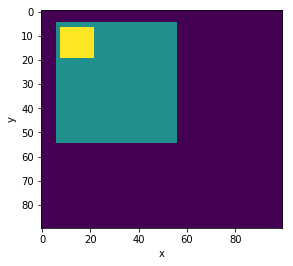

In [81]:
# initialize a zero template

template = np.zeros((M, N))
# draw a box on template
template[5:55, 6:56] = 10
template[7:20, 8:22] = 20
# template[60:100, 70:100] = 20
plt.imshow(template)
plt.xlabel("x")
plt.ylabel("y")

### 2. create reference image

In [82]:
reference = np.zeros(template.shape)
import math
angle = -5*math.pi/180.0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
transformMatrix = np.array([[angle_cos, -angle_sin, -30.0],[angle_sin, angle_cos, 4.0],[0.0, 0.0, 1.0]])

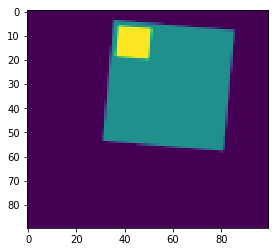

In [83]:
newImage, _, _ = biInterpolate(template, transformMatrix) # May have some edge problem
reference = newImage
plt.imshow(reference)

### 3. Gradient Descent

In [85]:
transMatrix = np.array([[1.0, 0.0, 0.0],[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]])
lr = 1e-8
i = 0
losses = []
iteration = 50000
while i < iteration:
    moving, dTx, dTy = biInterpolate(template, transMatrix)
    delta_weights = calGradient(reference, moving, dTx, dTy, lr)
    gradientCheck(transMatrix, delta_weights*1e8)
    transMatrix -= delta_weights
    loss = calLoss(moving, reference)
    i += 1
    losses.append(loss)
    if i%1000 == 0:
        plt.figure(i//1000)
        plt.imshow(moving)
        print(loss)



-99938.5159672872 247192.11767660454
1.0
-58736.45515709015 -58736.45510291681
4.6115607439461663e-10
-39029.81771490029 -39029.817562550306
1.9517126978806343e-09
-28174.713592161857 -28174.713952466846
6.39411976012576e-09
-21663.274708037115 -21663.274965249002
5.936588268196408e-09
-17519.942404082292 -17519.942193757743
6.002432716665851e-09
-14744.685096560454 -14744.685031473637
2.207128081088748e-09
-12786.746653730414 -12786.74666536972
4.55131631585524e-10
-1575.4251924450764 -1575.425558257848
1.1609968245937733e-07
20320.87226530011 20320.872135926038
3.183280478096901e-09
191146.1430182699 191146.14318823442
4.4459308585254895e-10
451525.7485792934 451525.7486491464
7.735221636436848e-11
231738.23853342468 231738.23836259544
3.68582331031724e-10
220744.45017607894 220744.45005273446
2.793829655365497e-10
258507.859259378 258507.8589618206
5.755287073097389e-10
255333.08125480326 255333.08129524812
7.920020662421966e-11
236633.81652927696 236633.81638471037
3.05464760018975

-27403.74790753216 -27403.74780842103
1.808349913039392e-09
-16300.305351101153 -16300.305287586525
1.9482649784037212e-09
-18534.065901661204 -18534.06589361839
2.1697382774257068e-10
-14485.402844251572 -14485.40308047086
8.153700961590089e-09
-9207.140996837566 -9207.14097446762
1.2148150154092927e-09
-11127.04113577187 -11127.041216241196
3.6159354978614156e-09
-9342.90599661303 -9342.906123492867
6.790169786721478e-09
-18598.41259229502 -18598.41257100925
5.722469660003926e-10
-24714.518332934244 -24714.518222026527
2.24377662036689e-09
-14651.204704268866 -14651.204837718979
4.554236808586819e-09
-36058.762868807855 -36058.76278015785
1.2292435831512496e-09
-20979.14737021865 -20979.147229809314
3.346402324050256e-09
-23127.796299702895 -23127.796303015202
7.160878842759055e-11
-12136.105152684264 -12136.105069657788
3.4206393008235895e-09
-21931.94889754556 -21931.94901337847
2.640734545729973e-09
-24830.6187857083 -24830.618785927072
4.405316988480014e-12
-15584.01800966871 -15

-18976.39263359341 -18976.392602780834
8.11865963422849e-10
-18038.735877570056 -18038.73587050475
1.9583700705730886e-10
-10422.058555809897 -10422.058694530278
6.655133408030978e-09
-19968.97291943428 -19968.97262870334
7.279566713401982e-09
-9889.021202609176 -9889.021166600287
1.8206497985683001e-09
-14025.234221468505 -14025.234268046916
1.6605216616840656e-09
-19708.375020854088 -19708.375039044768
4.6149618655109323e-10
-10728.081531904609 -10728.081688284874
7.288361094564962e-09
-19750.140966618783 -19750.141073018312
2.6936397443133803e-09
-10010.822648578614 -10010.822588810697
2.985165132815341e-09
-17961.49241292957 -17961.4924127236
5.733593941091987e-12
2606.5518363527954 2606.5520069096237
3.271694435936934e-08
-606.8046609450539 -606.8048242013901
1.3452130873604103e-07
-1849.626892821514 -1849.6268603485078
8.778258657681905e-09
-13093.525716619682 -13093.52577663958
2.29196854192603e-09
-23295.201200996642 -23295.20124476403
9.394078110762283e-10
-27922.614479685053 

-19241.208296406345 -19241.208356106654
1.5513659031651104e-09
-10967.386650356173 -10967.386770062149
5.45736093220483e-09
-6703.020127298805 -6703.020044369623
6.185956556689746e-09
-12659.927244019085 -12659.927306231111
2.4570451579697086e-09
-5103.369478467444 -5103.369330754504
1.4472099617399364e-08
-13515.5753177226 -13515.575119527057
7.332116454585799e-09
-11228.630178635533 -11228.630319237709
6.260878371902956e-09
-10760.526090231957 -10760.526056401432
1.571973578384881e-09
-10010.974211338005 -10010.974074248224
6.846975070020784e-09
-9382.240624159196 -9382.240241393447
2.039841933166616e-08
-8779.426385540923 -8779.426425462589
2.2735919287861e-09
-8217.977728150436 -8217.977738240734
6.139161206650004e-10
-7692.118370639277 -7692.118233535439
8.91196888362728e-09
-7150.776618929289 -7150.77665518038
2.5347659962406592e-09
-6694.836345458346 -6694.836192764342
1.1403863960410804e-08
-20885.632784860645 -20885.63283905387
1.2973804659725614e-09
-38767.42079259409 -38767.

-25443.703855423082 -25443.70378018357
1.4785487614897948e-09
-22849.99295795901 -22849.993110867217
3.345913654168739e-09
-6003.850667790219 -6003.850576234981
7.624709796138157e-09
-7637.623040643201 -7637.623202754185
1.0612659239660696e-08
-6903.024807873648 -6903.0249142088
7.702069316069726e-09
-6516.476541212323 -6516.4765692316
2.149879308037282e-09
3490.1592933209613 3490.159288048744
7.552974887091313e-10
-14085.989690658287 -14085.989823797718
4.725952270302911e-09
-6521.774819253653 -6521.774921566248
7.843922639988795e-09
-7018.675097536588 -7018.675096333027
8.573987950575501e-11
-20718.03887027997 -20718.038722407073
3.5686991640860368e-09
-438.811895529303 -438.81169403903186
2.2958620704023199e-07
-8035.912985364557 -8035.912906052545
4.934847668628527e-09
-1020.2301756829838 -1020.2302655670792
4.405088848697662e-08
-8982.067208279623 -8982.067374745384
9.266561679920208e-09
-7447.394710213587 -7447.394746122882
2.410862855331098e-09
-7120.348667346058 -7120.348600437

-4531.3173374099715 -4531.317390501499
5.8582883736663466e-09
-4162.45972914336 -4162.459808867425
9.576556770123397e-09
-3928.128589429311 -3928.128571715206
2.254776633014213e-09
-3695.8276805001956 -3695.8274722564965
2.8172810382972768e-08
-3489.0129371813096 -3489.0130336862057
1.3829827603754331e-08
-3272.483119594399 -3272.483154432848
5.322937926843086e-09
-18685.36116208043 -18685.361137613654
6.547043742294357e-10
-2480.009915902774 -2480.0100072752684
1.8421799865359448e-08
-4149.537138049753 -4149.537126068026
1.443742576049347e-09
-3703.2067696694576 -3703.2067484688014
2.8624726583868073e-09
-3499.0579045609343 -3499.057929730043
3.59655500645308e-09
-88.2889750956383 -88.28879799693823
1.0029501277341097e-06
-4746.084091756726 -4746.084014186636
8.172009724711644e-09
-3919.1211810916716 -3919.1212272271514
5.885947053294605e-09
-3756.7211811287852 -3756.721271201968
1.1988270824930499e-08
-3527.031587269041 -3527.031367411837
3.1167457058631787e-08
279.1155088067753 279.

-1039.1422485065996 -1039.1422256361693
1.1004475345755912e-08
-980.0108182664554 -980.0106636248529
7.889791207066057e-08
-924.3420613843774 -924.3420208804309
2.190960958015842e-08
-871.9327833935677 -871.9328616280109
4.4862655234678156e-08
-822.5920777219872 -822.591973701492
6.32272693809103e-08
-776.1401774104743 -776.140223024413
2.9385115406302724e-08
-732.4078588734847 -732.4079342652112
5.14684009562715e-08
-691.2358157174895 -691.2359094712883
6.781606969356258e-08
-3452.3916704653243 -3452.39182934165
2.300960279459162e-08
2812.740712088067 2812.7405676059425
2.5683513536586346e-08
-3847.475509068172 -3847.475745715201
3.0753544903166925e-08
2926.08337019576 2926.0832525324076
2.0105947056874482e-08
-3804.0052285263664 -3804.0052459109575
2.2850377382013897e-09
2974.715694368322 2974.7157532256097
9.892926413480269e-09
-3758.5831138024514 -3758.5830432362854
9.387336196285555e-09
3016.890007806738 3016.8901139404625
1.758992243477046e-08
-3718.1739750836864 -3718.1739753577

KeyboardInterrupt: 

In [ ]:
plt.figure(1)
plt.imshow(reference)
plt.figure(2)
plt.imshow(template)
plt.figure(3)
plt.imshow(moving)

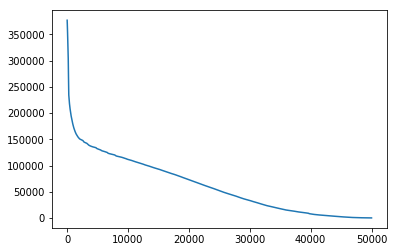

In [13]:
plt.plot(np.arange(iteration), losses)